In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import csv
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools

In [2]:
data=pd.read_csv("temp2.csv")

In [3]:
data.loc[:,"Activity Period"] = pd.to_datetime(data.loc[:,"Activity Period"].astype(str), format="%Y%m")
data.loc[:,"Year"] = data["Activity Period"].dt.year
data.loc[:,"Month"] = data["Activity Period"].dt.month

In [4]:
time_begin = data.loc[:,"Activity Period"].min()
time_end = data.loc[:,"Activity Period"].max()
time_range = time_end-time_begin

print("First date: ", str(time_begin)[:11])
print("Last date: ", str(time_end)[:11])
print("Time range in days:", time_range.days)
print("Time range in months:", time_range/np.timedelta64(1,"M"))

First date:  2005-07-01 
Last date:  2016-02-01 
Time range in days: 3867
Time range in months: 127.04983675229471


In [5]:
data.head()

,Unnamed: 0,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight,Year,Month
0,4866,2016-02-01,Delta Air Lines,DL,Delta Air Lines,DL,Domestic,US,Passenger,Wide Body,Boeing,767,300.0,35,10325000,2016,2
1,4867,2016-02-01,Delta Air Lines,DL,Delta Air Lines,DL,Domestic,US,Passenger,Narrow Body,Boeing,757,300.0,31,6944000,2016,2
2,4869,2016-02-01,Delta Air Lines,DL,Delta Air Lines,DL,Domestic,US,Passenger,Wide Body,Boeing,747,400.0,1,630000,2016,2
3,4870,2016-02-01,Alaska Airlines,AS,Alaska Airlines,AS,International,Mexico,Passenger,Narrow Body,Boeing,737,900.0,12,1755600,2016,2
4,4871,2016-02-01,Alaska Airlines,AS,Alaska Airlines,AS,Domestic,US,Passenger,Narrow Body,Boeing,737,900.0,70,10241000,2016,2


##Droping Columns except Activity Period and Landing Count

In [7]:
data=data.loc[:,data.columns.isin(['Activity Period', 'Landing Count'])].reset_index(drop=True).sort_values('Activity Period')

In [8]:
data=data.set_index('Activity Period')
data.index

DatetimeIndex(['2005-07-01', '2005-07-01', '2005-07-01', '2005-07-01',
               '2005-07-01', '2005-07-01', '2005-07-01', '2005-07-01',
               '2005-07-01', '2005-07-01',
               ...
               '2016-02-01', '2016-02-01', '2016-02-01', '2016-02-01',
               '2016-02-01', '2016-02-01', '2016-02-01', '2016-02-01',
               '2016-02-01', '2016-02-01'],
              dtype='datetime64[ns]', name='Activity Period', length=13914, freq=None)

In [9]:
y=data['Landing Count'].resample('MS').mean()

In [10]:
y[0:15]

Activity Period
2005-07-01    100.027778
2005-08-01    105.067961
2005-09-01    100.901961
2005-10-01     96.224299
2005-11-01     91.902913
2005-12-01     94.039216
2006-01-01     87.227723
2006-02-01     88.565217
2006-03-01     86.220000
2006-04-01     93.336842
2006-05-01     95.020619
2006-06-01    100.260417
2006-07-01    103.666667
2006-08-01    115.927083
2006-09-01     89.490196
Freq: MS, Name: Landing Count, dtype: float64

<AxesSubplot:xlabel='Activity Period'>

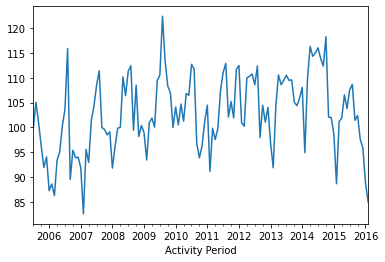

In [11]:
y.plot()

In [12]:
y_train=y[:len(y)-11]
y_test=y[(len(y)-11):]

<AxesSubplot:xlabel='Activity Period'>

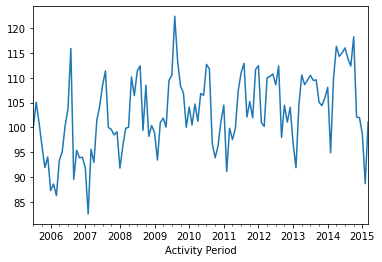

In [13]:
y_train.plot()

<AxesSubplot:xlabel='Activity Period'>

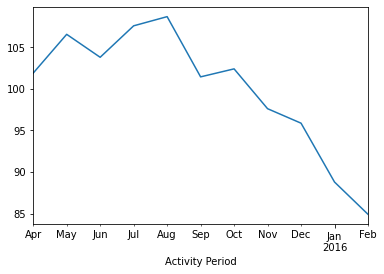

In [14]:
y_test.plot()

In [15]:
y_train[0:2]

Activity Period
2005-07-01    100.027778
2005-08-01    105.067961
Freq: MS, Name: Landing Count, dtype: float64

In [16]:
y_train[-2:]

Activity Period
2015-02-01     88.632479
2015-03-01    101.148760
Freq: MS, Name: Landing Count, dtype: float64

In [17]:
y_test[0:2]

Activity Period
2015-04-01    101.897436
2015-05-01    106.559322
Freq: MS, Name: Landing Count, dtype: float64

In [18]:
y_test[-2:]

Activity Period
2016-01-01    88.800000
2016-02-01    84.918699
Freq: MS, Name: Landing Count, dtype: float64

##Ad Fuller test to check stationarity

In [19]:
result=adfuller (y_train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) 
print("Critical Values:")

for key, value in result[4].items(): 
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.791655
p-value: 0.384613
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


##Time Series Decomposition

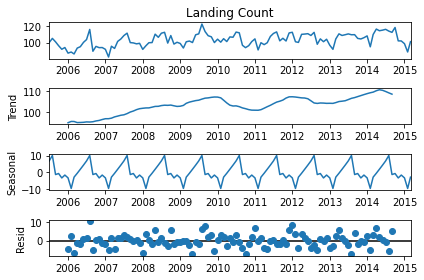

In [20]:
ts_decomp=sm.tsa.seasonal_decompose(y_train, model='additive')

ts_decomp.plot()

plt.show()

##Determining parameters for SARIMAX Model

In [21]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Examples of parameter confinations for Seasonal ARIMA...")
print('SARIMAX: {} x {}' .format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}' .format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}' .format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}' .format(pdq[2], seasonal_pdq[4]))
print('SARIMAX: {} x {}' .format(pdq[3], seasonal_pdq[5]))

Examples of parameter confinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
SARIMAX: (0, 1, 1) x (1, 0, 1, 12)


In [22]:
metric_aic_dict=dict()

for pm in pdq:
    for pm_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=pm,
                                              seasonal_order=pm_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            model_aic=model.fit()
            print('ARIMA{}x{}12 - AIC:{}' .format(pm,pm_seasonal,model_aic.aic))
            metric_aic_dict.update({(pm.pm_seasonal):model_aic.aic})
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1407.1709298722835
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1158.9805692690165
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:694.5112125121004
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:597.6978888868321
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:698.3753687361445
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:657.5458625738737
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:598.614258036882
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:593.7393812170045
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1249.308971356644
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1018.8618149447051
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:677.4730523004754
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:571.0359098880682
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:690.9443811874349


C:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:680.321439375739
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:580.9741665121661
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:570.2212577696444
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:773.2775959844175
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:685.2337836690714
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:705.4694542967723
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:567.8265876081832
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:684.5443035063699
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:659.2499210127162
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:583.7590510836143
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:574.4591461216529
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:756.5399301374252
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:651.3164540369286
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:655.8157003323539
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:548.1135249875982
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:657.9877637495799
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:615.6875913789198
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:565.8039999829541
ARIMA(0, 1,

In [50]:
{k: v for k, v in sorted(metric_aic_dict.items(), key=lambda x: x[1])}

{}

##Fitting model as per the lowest aic

In [24]:
model = sm.tsa.statespace.SARIMAX(y_train,
                                 order=(1,1,1),
                                 seasonal_order=(0,1,1,12),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
model_aic = model.fit()
print(model_aic.summary().tables[1])                        

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4847      0.112      4.314      0.000       0.264       0.705
ma.L1         -0.9518      0.066    -14.478      0.000      -1.081      -0.823
ma.S.L12      -0.7136      0.127     -5.618      0.000      -0.963      -0.465
sigma2        21.6981      4.524      4.796      0.000      12.831      30.565


##Model Diagnostic plot to check the residuals

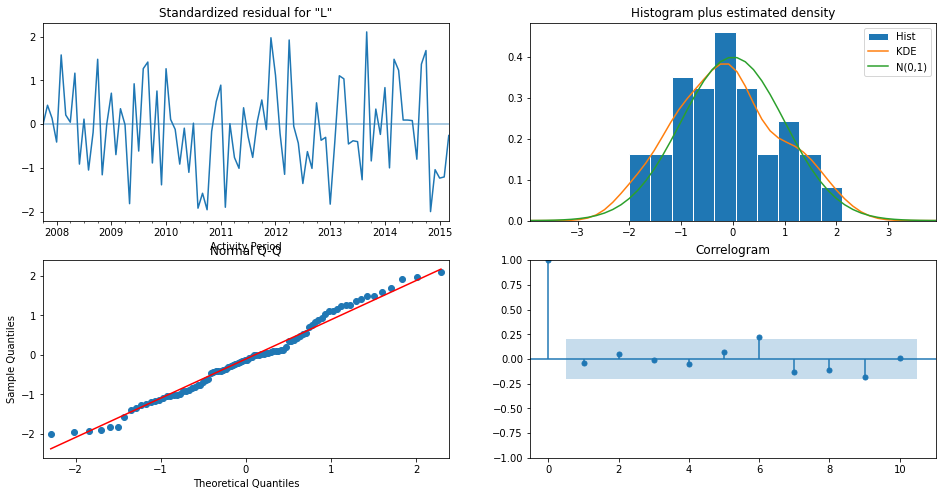

In [25]:
model_aic.plot_diagnostics(figsize=(16,8))
plt.show()

##Claculating Root Mean Square Error of our forcast by test data

In [27]:
forecast= model_aic.get_prediction(start=pd.to_datetime('2015-04-01'), dynamic=False)
predictions= forecast.predicted_mean

actual=y_test['2015-04-01':]
rmse= np.sqrt((predictions- actual)**2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 6.39


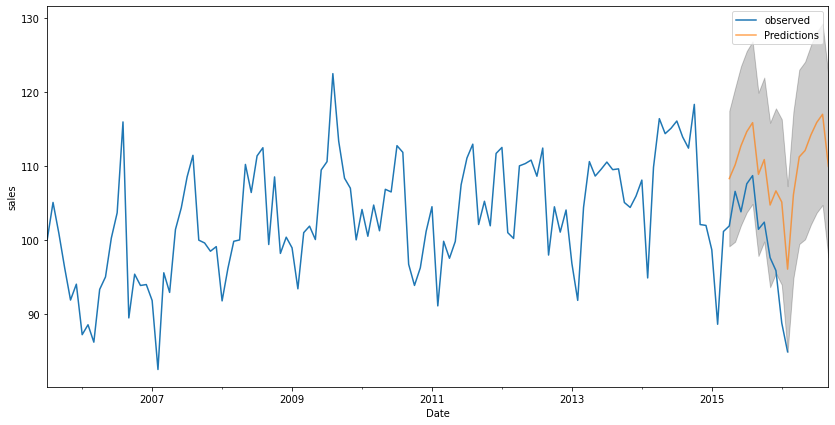

In [28]:
forecast= model_aic.get_forecast(steps=18)

##predictions and confidence interval
predictions= forecast.predicted_mean
ci= forecast.conf_int()

##observed Plot
fig=y.plot(label='observed', figsize= (14, 7)) 
fig.set_xlabel('Date')
fig.set_ylabel('sales')
fig.fill_between(ci.index,
                 ci.iloc[:,0],
                 ci.iloc[:,1],color='k',alpha=.2)

##prediction plot 
predictions.plot(ax=fig, label='Predictions', alpha=.7, figsize=(14, 7))


plt.legend()
plt.show()